<a href="https://colab.research.google.com/github/MonicaKim89/Arthritis_Classification/blob/main/%5B0101%5Dunet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob
import math
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import Image

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils
import xml.etree.ElementTree as ET


#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.image as mpimg
from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},style='darkgrid')


In [2]:
import random 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

In [3]:
import tensorflow as tf

In [4]:
%cd /content/drive/MyDrive/Projects/knee/unet_train

/content/drive/MyDrive/Projects/knee/unet_train


In [5]:
def get_file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
    
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

def INPUT_IMG(path):
    i = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return img

def get_img(path):
    data_path = os.path.join(path, '*png')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_list.append(img)

    return img_list

def count_img(path):
    os.chdir(path)
    files = os.listdir(path)
    for num, i in enumerate(files):
        if i[-1] =='g':
            num +=1
    print('이미지 수', num)

def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

seed = 1337
os.environ['PYTHONHASHSEED']= str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS']= '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [6]:
#사진확인용 opencv사용해서 color 로 열리는데 grayscale 이미지
train_img_list = get_img(train_path)
show(train_img_list[0])
print(train_img_list[0].shape)

NameError: ignored

In [ ]:
seg_img_list = get_img(seg_path)
show(seg_img_list[0])
print(seg_img_list[0].shape)

### DATA

In [7]:
TRAIN_PATH = '/content/drive/MyDrive/Projects/knee/unet_train/dataset_keras/'
TEST_PATH = '/content/drive/MyDrive/Projects/knee/Knee_dataset/3/'

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 1

In [9]:
#read train image
train_ids = next(os.walk(TRAIN_PATH))[1] #subfolder extract
test_ids = next(os.walk(TEST_PATH))[2]

In [10]:
#empty array 만들기 as same dimension 
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)


In [11]:
# type(X_train)
type(Y_train)

numpy.ndarray

In [12]:
next(os.walk(path + '/mask/'))

NameError: ignored

In [13]:
# img_test = imread('/content/drive/MyDrive/Projects/knee/unet_train/dataset_keras/9000099L/mask/9000099L.png')[:,:]
# img_s =cv2.imread('/content/drive/MyDrive/Projects/knee/unet_train/dataset_keras/9000099L/mask/9000099L.png', cv2.IMREAD_GRAYSCALE)

# img_s = img_s[...,None]
# show(img_s)
# print(img_s.shape)

In [14]:
mask_ = cv2.imread(path + '/mask/' + mask_file, 0)
print(mask_.shape)

NameError: ignored

In [15]:
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
type(mask)

numpy.ndarray

In [16]:
#Train Image

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_ + '.png')[:,:] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = cv2.imread(path + '/mask/' + mask_file, cv2.IMREAD_GRAYSCALE) ## color Channel이 4로 나와서 그레이스케일로 뽑음
        # mask_ = mask_.reshape(224,224,1)
        # print(mask_.shape)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        # print(mask.shape)
    Y_train[n] = mask

100%|██████████| 49/49 [00:00<00:00, 52.23it/s]


In [17]:
#Test Image
X_test = np.zeros((len(test_ids),224,224), dtype= np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids[:20]), total = len(test_ids[:20])):
    path = '/content/drive/MyDrive/Projects/knee/Knee_dataset/3/'
    img = imread(path+id_)
    # print(img.shape)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img

print('Done')

100%|██████████| 20/20 [00:01<00:00, 17.47it/s]

Done


### Image Check

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


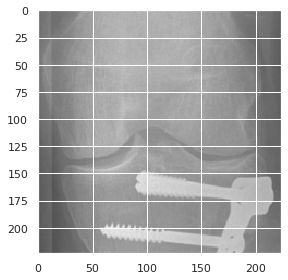

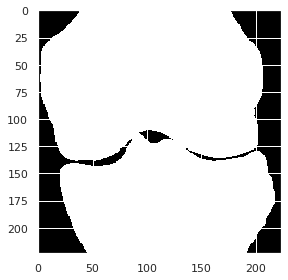

In [18]:
import random
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

### Model

In [19]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) #define input layer
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) #소숫점으로 바꿔줘야함(int-->float) (레이어에 파이썬 람다펑션사용) 

#Contraction path (Encoder)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)#normal = 가우시안
c1 = tf.keras.layers.Dropout(0.1)(c1) #drop 10% from c1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) 

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path (Decoder)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) #upscaling/Conv2DTranspose
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 


outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #back propogation 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [20]:
#model checkpoint
# Call the above function with seed value
# set_global_determinism(seed=1337)

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_niclei.h5', verbose = 1, save_best_only=True)
call_back = [
             tf.keras.callbacks.EarlyStopping(patience=2, monitor= 'val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [23]:
results = model.fit(X_train, Y_train, validation_split =0.1, batch_size = 16, epochs = 100, callbacks=call_back)


Epoch 1/100
3/3 [==============================] - 1s 347ms/step - loss: 0.2321 - accuracy: 0.9201 - val_loss: 0.2820 - val_accuracy: 0.8932
Epoch 2/100
3/3 [==============================] - 1s 322ms/step - loss: 0.2288 - accuracy: 0.9209 - val_loss: 0.2714 - val_accuracy: 0.8939
Epoch 3/100
3/3 [==============================] - 1s 327ms/step - loss: 0.2135 - accuracy: 0.9225 - val_loss: 0.2976 - val_accuracy: 0.8978
Epoch 4/100
3/3 [==============================] - 1s 324ms/step - loss: 0.2206 - accuracy: 0.9220 - val_loss: 0.2698 - val_accuracy: 0.9002
Epoch 5/100
3/3 [==============================] - 1s 331ms/step - loss: 0.2388 - accuracy: 0.9209 - val_loss: 0.2753 - val_accuracy: 0.9046
Epoch 6/100
3/3 [==============================] - 1s 322ms/step - loss: 0.2199 - accuracy: 0.9234 - val_loss: 0.2533 - val_accuracy: 0.9027
Epoch 7/100
3/3 [==============================] - 1s 329ms/step - loss: 0.2098 - accuracy: 0.9246 - val_loss: 0.3026 - val_accuracy: 0.8819
Epoch 8/100
3

### TEST

In [24]:
idx = random.randint(0, len(X_train))

#value (0~1)로 나오는데 0.5 이상을 기준으로 binary로 만듦
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose =1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose =1)

preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test>0.5).astype(np.uint8)

40/40 [==============================] - 9s 237ms/step


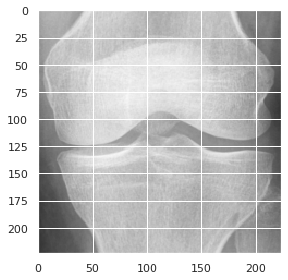

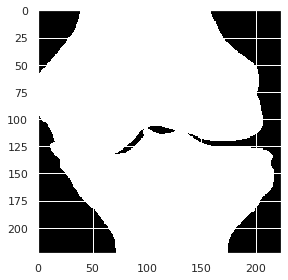

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


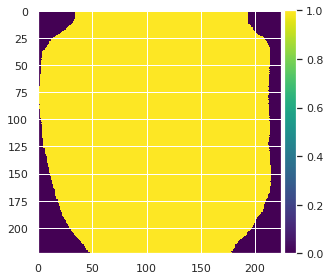

In [31]:
#Perform a sanity check on some random training samples
ix = 1
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()